# Short Interpolation using Kriging

In [98]:
import numpy as np
import statistics as stat
import scipy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import PrizmCalibration as cl # this module is missing dependencies
from gsm_data import GSMData, get_desired_frequencies
# from data_prep import DataPrep

# For reloading the module (useful for debugging)
import data
import data_prep
try:
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep
except:
    from importlib import reload
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep

from helper_functions import *
import data_utils as du

import copy

try:
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt
except:
    import test_short_interp
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt

from numpy.polynomial import polynomial as P

## Step 0: Load in data

In [2]:
# Flag the 'bad' spectra
# For a first pass I have to fetch the mask from DataPrep
year = '2021'
instrument = '100MHz'
channel = 'NS'

dataprep = DataPrep(instrument, channel, year)
save_mask = copy.deepcopy(dataprep.calib_mask_dict['short']) # save the mask

TypeError: object of type 'NoneType' has no len()

In [46]:
# Actually save the mask so I don't have to load it in every time anymore.
np.save(datadir+'shortdata_2021_100MHz_NS_mask.npy',save_mask)

In [99]:
datadir = '../test_data/2021/100MHz/NS/'

save_mask = np.load(datadir+'shortdata_2021_100MHz_NS_mask.npy')
dat=np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')[save_mask]
lst=np.load(datadir+'shortlst_2021_100MHz_NS.npy')[save_mask]
t=np.load(datadir+'shortsystime_2021_100MHz_NS.npy')[save_mask]

# dat_nomask = np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')
# lst_nomask = np.load(datadir+'shortlst_2021_100MHz_NS.npy')
# t_nomask = np.load(datadir+'shortsystime_2021_100MHz_NS.npy')

In [100]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
minfreq = 30
maxfreq = 200
minfreqarg = int(minfreq/freqstep)
maxfreqarg = int(maxfreq/freqstep)

In [22]:
print(np.diff(t_nomask))
tmax=1.6374e9
tmin=1.6365e9
freq = 100 # MHz
freq_index = int(freq/freqstep)
mask=(t_nomask>tmin)&(t_nomask<tmax)
plt.figure(figsize=(20,5))
plt.plot((t_nomask[mask]-t_nomask[mask][0])/3600,dat_nomask[mask,:][:,freq_index],'.',label='Selected section',zorder=0)

NameError: name 't_nomask' is not defined

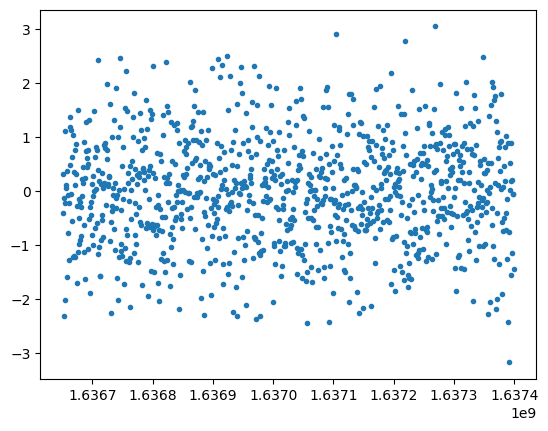

In [238]:
# White Gaussian Noise simulated data -- for testing purposes
twgn = np.linspace(np.min(tt),np.max(tt),1000)
wgn_data = np.random.normal(loc=0,scale=1,size=len(twgn))

plt.plot(twgn,wgn_data,'.',label='WGN data')
plt.show()

## Step 1: Compute the autocorrelation function (ACF)

For now (testing purposes) we restrict to:

- one frequency channel: 100 MHz

- one section of the time series

- one data point to interpolate

tvec[wt>30]: [     5     10     15 ... 172770 172775 172780]
tvec2[wt2>30]: [     0      5     10 ... 172770 172775 172780]


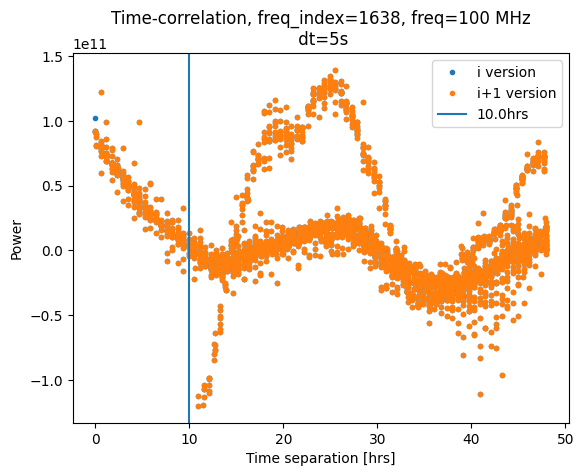

In [194]:
tmax=1.6374e9
tmin=1.6365e9

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

''' Set frequency here'''
freq = 100 # MHz
freq_index = int(freq/freqstep)
'''-----------------------------'''

dt=5 # seconds
plt.clf()

tot,wt=make_acf((dd[:,freq_index]-dd[:,freq_index].mean()),tt,dt=dt,tmax=2*86400)
tot2,wt2=make_acf_alt(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
# tot,wt=make_acf(dd-dd.mean(),tt,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
tvec2=np.arange(len(tot2))*dt
mm=wt>30
mm2=wt2>30
print('tvec[wt>30]:',tvec[mm])
print('tvec2[wt2>30]:',tvec2[mm2])

plt.plot(tvec2[mm2]/3600,(tot2[mm2]/wt2[mm2]),'.',label='i version')
plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='i+1 version')

'''Set dtmax here -- i.e. the section of the ACF data used to fit a function'''
dtmax = 10*3600 # seconds
'''------------------------------------'''

plt.axvline(x=dtmax/3600,label=str(dtmax/3600)+'hrs')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.legend()
plt.show()

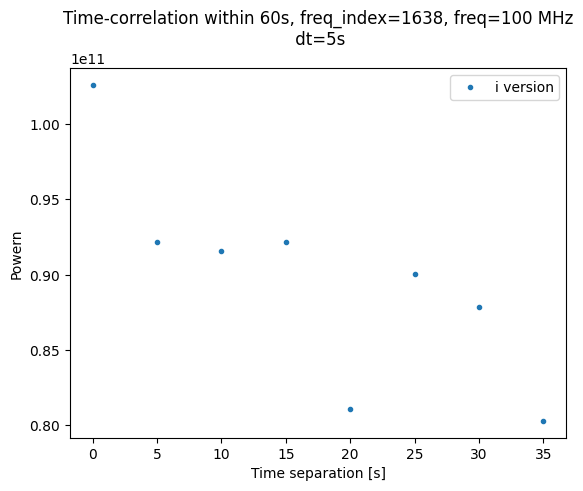

[ 0  5 10 15 20 25 30 35]


In [211]:
plt.plot(tvec2[mm2][tvec2[mm2]<60],(tot2[mm2]/wt2[mm2])[tvec2[mm2]<60],'.',label='i version')

plt.title('Time-correlation within 60s, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Powern')
plt.xlabel('Time separation [s]')
plt.legend()
plt.show()

print(tvec2[mm2][tvec2[mm2]<60])

In [195]:
# Use the dt=0 inclusive method
# tot,wt = tot2, wt2
# tvec = tvec2
# mm = mm2
print(tvec2[mm2])
print(tvec[mm])

[     0      5     10 ... 172770 172775 172780]
[     5     10     15 ... 172770 172775 172780]


In [7]:
print(np.min(np.diff(tt))) # minimum timestep between consecutive samples, in seconds
# trying to set a dt < this for the ACF computation, to ensure there is no zero bin
print(np.diff(tt)[-19:])

5.330339670181274
[2067.41713333    6.55352545    6.4377284     6.58449221    6.10618496
    6.6989305  2067.72744346    7.01444149    6.36022449    6.10643244
    7.11959314    6.2536571     6.23910093 2067.83067584    7.13539553
    6.17734051    6.19060159    6.11703444    6.86239862]


Since the autocorrelation function still looks a little weird, we will only focus use the dt = 0 to dt = 8h section.

Also we plot the data:

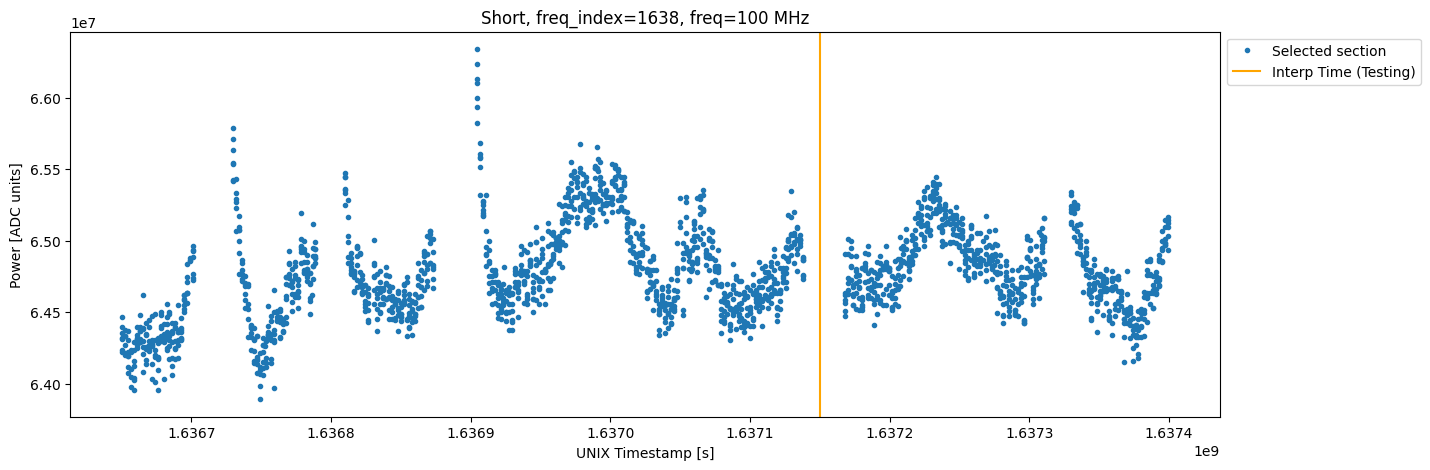

In [184]:
# vs UNIX timestamp

''' Set interp_time here'''
interp_time = 1.63715e9
'''--------------------'''

plt.figure(figsize=(20,5))
# plt.plot(t,dat[:,freq_index],'.',label='All times')
plt.plot(tt,dd[:,freq_index],'.',label='Selected section')
plt.axvline(x=interp_time,label='Interp Time (Testing)',color='orange') 
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

# Step 2: Fit the autocorrelation function

In [185]:
# As a simple first pass for just the 0 to 8h section of the ACF we 
def linfunc(x,a,b):
    return a*x+b

def expfunc(x,a,b):
    return a*np.exp(-x/b)

# def expabsfunc(x,a,b):
#     return a*np.exp(-b*abs(x))

def ACF_fit(a,b,functype='linear'):
    if functype == 'linear':
        return lambda dt: a*dt+b
    elif functype == 'exponential':
        return lambda dt: a*np.exp(-dt/b)

def ACF_wgn(dt):
    if dt == 0: return np.random.normal(loc=1,scale=0.03,size=1)
    else: return np.random.normal(loc=0,scale=0.03,size=1)

[-8.38361149e+09  8.13635710e+10]
[-8.42596300e+09  8.16515798e+10]


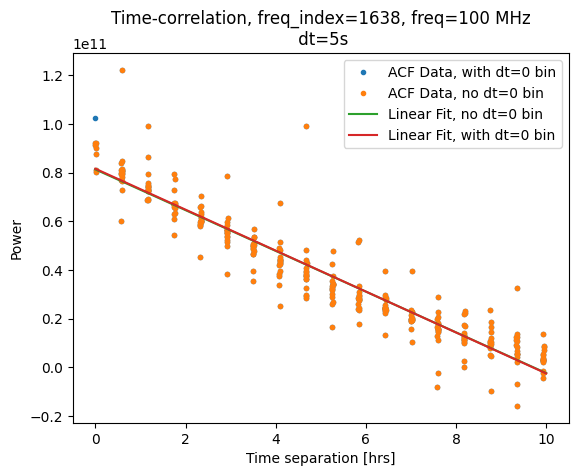

In [201]:
plt.plot(tvec2[mm2][tvec2[mm2]<dtmax]/3600,(tot2[mm2]/wt2[mm2])[tvec2[mm2]<dtmax],'.',label='ACF Data, with dt=0 bin')
plt.plot(tvec[mm][tvec[mm]<dtmax]/3600,(tot[mm]/wt[mm])[tvec[mm]<dtmax],'.',label='ACF Data, no dt=0 bin')

tfitvec = np.linspace(0,dtmax/3600,100)

# Do the fit:

# ------------ exp or linear

popt, pcov = scipy.optimize.curve_fit(f=linfunc,xdata=tvec[mm][tvec[mm]<dtmax]/3600,ydata=(tot[mm]/wt[mm])[tvec[mm]<dtmax],p0=[-6e10/8,9.1e10])
plt.plot(tfitvec,linfunc(tfitvec,popt[0],popt[1]),label='Linear Fit, no dt=0 bin')
popt2, pcov2 = scipy.optimize.curve_fit(f=linfunc,xdata=tvec2[mm2][tvec2[mm2]<dtmax]/3600,ydata=(tot2[mm2]/wt2[mm2])[tvec2[mm2]<dtmax],p0=[-6e10/8,9.1e10])
plt.plot(tfitvec,linfunc(tfitvec,popt2[0],popt2[1]),label='Linear Fit, with dt=0 bin')
# # popt, pcov = scipy.optimize.curve_fit(f=expfunc,xdata=tvec[mm][tvec[mm]<dtmax]/3600,ydata=(tot[mm]/wt[mm])[tvec[mm]<dtmax],p0=[9.1e10,4])
# # plt.plot(tfitvec,expfunc(tfitvec,popt[0],popt[1]),label='Exp Fit')
# # popt, pcov = scipy.optimize.curve_fit(f=expabsfunc,xdata=tvec[mm][tvec[mm]<dtmax]/3600,ydata=(tot[mm]/wt[mm])[tvec[mm]<dtmax],p0=[9.1e10,4])
# # plt.plot(tfitvec,expabsfunc(tfitvec,popt[0],popt[1]),label='Exp Fit')

print(popt)
print(popt2)
ACF_func = ACF_fit(popt[0],popt[1],functype='linear')

# ------------------------------------------


# ---------------- using np.polyfit
# c = np.polyfit(x=tvec[mm][tvec[mm]<dtmax]/3600,y=(tot[mm]/wt[mm])[tvec[mm]<dtmax],deg=4)
# ACF_func = np.poly1d(c)
# plt.plot(tfitvec,ACF_func(tfitvec),label='Poly')
# ----------------------------------------------


plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.legend()
plt.show()

## Step 3: Build the covariance matrix

In [178]:
# "d": the data array, for convenience we put the point where we want to interpolate (marked by a 0) at the end 
# of the array of existing data

# "C": the covariance matrix of data d
'''Making a matrix with only the data within 8h of the interp time'''
# I had to reduce to 8h total (4h around interp time) interval so there's no need to use the ACF at dt > 8h
d_red = dd[abs(tt - interp_time) < dtmax/2,freq_index] 
t_red = tt[abs(tt - interp_time) < dtmax/2]
d = np.append(d_red,0)
tarr = np.append(t_red,interp_time)
C = np.zeros(shape=(len(d),len(d))) # initialize
'''--------------------------------------'''
# d = np.append(dd_gauss,0) # append 0 to end of data array
# d = np.append(dd,0)
# tarr = np.append(t_gauss,interp_time) # append the time where we want to generate an interpolated point
# C = np.zeros(shape=(len(d),len(d))) # initialize

for i in range(len(d)):
    for j in range(len(d)):
        dtij = abs(tarr[i]-tarr[j]) # time separation between points
        
        if dtij > dtmax:
            # For now, we are only using the ACF up to dt = 8 hours. If dtij > 8h, set C_ij = 0 (uncorrelated).
#             print('larger')
#             print(dtij)
            C[i,j] = 0
        else:
            
            C[i,j] = ACF_func(dtij/3600) # ACF_func is defined for dt in hours

## Step 4: Invert the covariance matrix

In [179]:
Cinv = np.linalg.inv(C)
# print(Cinv@C)

# U, Sdiag, VT = np.linalg.svd(C, full_matrices=False) # SVD
# Cinv_svd = VT.T @ np.diag(1/Sdiag) @ U.T
# print(Cinv_svd@C)

# lam, Q = scipy.linalg.eig(C) # eigenvector/value
# lam = np.real(lam)
# Q = np.real(Q)
# # print(lam)
# Cinv_eig = Q @ np.diag(1/lam) @ np.linalg.inv(Q)
# print(Cinv_eig@C)

# print(Cinv_svd.shape)
# print(Cinv.shape)
# print(Cinv_eig.shape)
# print(np.sum(abs(Cinv-Cinv_svd)))
# print(np.sum(abs(Cinv-Cinv_eig)))

## Step 5: Compute the weights for each data point

The interpolated value consists of a weighted sum of existing data, where the weights are given by:

$$ w[1..n]= \frac{-C^{-1}[n+1,1..n]}{C^{-1}[n+1][n+1]} $$

where $n$ is the number of measured data points, and $n+1$ is due to adding the new interpolated point to the end of the data array.

In [180]:
# "w": array of weights for the weighted sum to compute inteprolated value
n = len(d)-1
w = -Cinv[n,0:n] / Cinv[n,n]

## Step 6: Compute the weighted sum

In [181]:
dinterp = np.dot(w,d[0:n])
print(dinterp)
interp_err = np.sqrt(1/Cinv[n,n])
print(interp_err)
A = np.zeros(len(d))
A[n] = -1
interp_err = np.sqrt(1/(A.T@Cinv@A)) # just to verify it's the same thing
print(interp_err)

56026792.7306138
220548.52614438956
220548.52614438956


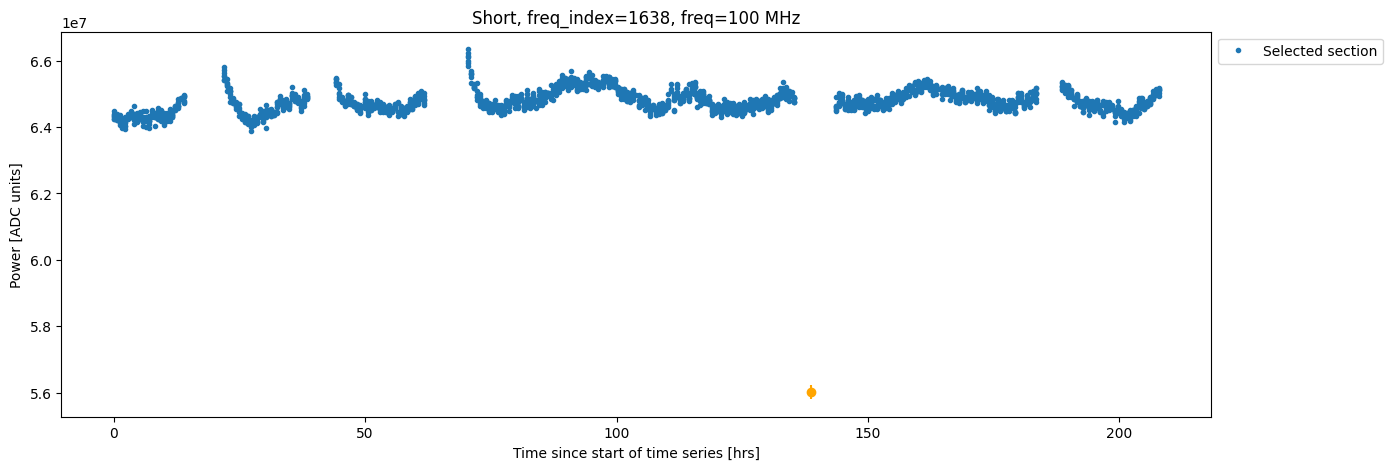

In [182]:
# Let's plot the result

plt.figure(figsize=(20,5))
plt.plot((tt-tt[0])/3600,dd[:,freq_index],'.',label='Selected section',zorder=0)
# plt.axvline(x=(interp_time-tt[0])/3600,label='Interp Time (Testing)',color='orange',zorder=1) 
plt.errorbar(x=(interp_time-tt[0])/3600,y=dinterp,yerr=interp_err,color='orange',marker='o')
plt.xlabel('Time since start of time series [hrs]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

Hmmmm ok this does not look good.
Try plotting the weights to make sure it works?
Maybe the problem is with the proper inversion of the C matrix. Look into matrix decomposition tricks from phys 512.

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


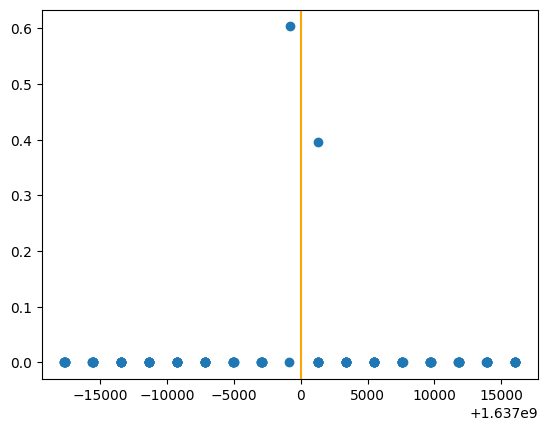

In [17]:
# plt.scatter(tt[abs(w)<100],w[abs(w)<100])
plt.scatter(t_red,w)
plt.axvline(x=interp_time,label='Interp Time (Testing)',color='orange') 
plt.show()

# why does this look like zero sometimes  and random other times????
# tt[w>200]